In [1]:
import os
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from typing import List, Tuple

def analyze_gradual_drift_adaptation(window_sizes: List[int],
                                   drift_range: Tuple[float, float],
                                   window_before: int = 10):
    """
    Analyze how window sizes change during gradual drift periods

    Parameters:
    window_sizes: List of window sizes from the approach
    drift_range: Tuple of (start_percentage, end_percentage) for drift period
    window_before: How many windows to analyze before drift for comparison

    Returns:
    dict: Analysis metrics
    """
    metrics = {}
    total_events = len(window_sizes)

    # Calculate drift period indices
    drift_start_idx = int(total_events * drift_range[0])
    drift_end_idx = int(total_events * drift_range[1])

    # Get windows before, during, and after drift
    pre_drift = window_sizes[max(0, drift_start_idx-window_before):drift_start_idx]
    during_drift = window_sizes[drift_start_idx:drift_end_idx]
    post_drift = window_sizes[drift_end_idx:]

    # Calculate average sizes for each period
    metrics['avg_pre_drift_size'] = np.mean(pre_drift)
    metrics['avg_during_drift_size'] = np.mean(during_drift)
    metrics['avg_post_drift_size'] = np.mean(post_drift)

    # Calculate relative changes
    metrics['relative_change_during_drift'] = (metrics['avg_during_drift_size'] -
                                             metrics['avg_pre_drift_size']) / metrics['avg_pre_drift_size']

    # Calculate variability during drift
    metrics['drift_period_cv'] = np.std(during_drift) / np.mean(during_drift)

    # Analyze adaptation trend during drift
    drift_period_changes = np.diff(during_drift)
    metrics['drift_period_trend'] = np.mean(drift_period_changes)
    metrics['drift_period_trend_std'] = np.std(drift_period_changes)

    # Calculate overall metrics
    metrics['overall_cv'] = np.std(window_sizes) / np.mean(window_sizes)

    # Calculate rate of change during drift vs non-drift
    non_drift_changes = np.concatenate([np.diff(pre_drift), np.diff(post_drift)])
    drift_changes = np.diff(during_drift)

    metrics['avg_change_rate_during_drift'] = np.mean(np.abs(drift_changes))
    metrics['avg_change_rate_non_drift'] = np.mean(np.abs(non_drift_changes))

    return metrics
def analyze_window_adaptation(window_sizes: List[int], drift_points: List[int],
                            window_before: int = 10, window_after: int = 20):
    """
    Analyze how window sizes change around known drift points

    Parameters:
    window_sizes: List of window sizes from the approach
    drift_points: List of indices where known drifts occur
    window_before: How many windows to analyze before drift
    window_after: How many windows to analyze after drift

    Returns:
    dict: Analysis metrics
    """
    metrics = {}

    # Analyze size changes around each drift point
    relative_changes = []
    for drift_idx in drift_points:
        if drift_idx >= window_before and drift_idx + window_after < len(window_sizes):
            # Get windows before and after drift
            pre_drift = window_sizes[drift_idx-window_before:drift_idx]
            post_drift = window_sizes[drift_idx:drift_idx+window_after]

            # Calculate average sizes and relative change
            avg_pre = np.mean(pre_drift)
            avg_post = np.mean(post_drift)
            rel_change = abs(avg_post - avg_pre) / avg_pre
            relative_changes.append(rel_change)

    metrics['mean_relative_change'] = np.mean(relative_changes)
    metrics['std_relative_change'] = np.std(relative_changes)

    # Calculate overall variability
    metrics['coefficient_of_variation'] = np.std(window_sizes) / np.mean(window_sizes)

    # Calculate average window sizes for drift vs non-drift periods
    all_drift_sizes = []
    non_drift_sizes = list(window_sizes)  # Copy list

    for drift_idx in drift_points:
        if drift_idx + window_after < len(window_sizes):
            drift_period = window_sizes[drift_idx:drift_idx+window_after]
            all_drift_sizes.extend(drift_period)
            # Remove these indices from non_drift_sizes
            for i in range(drift_idx, min(drift_idx+window_after, len(window_sizes))):
                non_drift_sizes[i] = None

    non_drift_sizes = [x for x in non_drift_sizes if x is not None]

    metrics['avg_drift_window_size'] = np.mean(all_drift_sizes)
    metrics['avg_non_drift_window_size'] = np.mean(non_drift_sizes)

    return metrics




len_map = {'cd-10000.csv': 127621, 'oir-10000.csv': 152225, 're-10000.csv': 123058, 'lp-10000.csv': 147912, 'rp-10000.csv': 127584, 'cb-10000.csv': 125447, 'rio-10000.csv': 130516, 'cp-10000.csv': 132900, 'iro-10000.csv': 138691, 'cf-10000.csv': 129986, 'ior-10000.csv': 129000, 'pm-10000.csv': 126002, 'cm-10000.csv': 125413, 'roi-10000.csv': 138012, 'sw-10000.csv': 128023, 'ori-10000.csv': 146212, 'pl-10000.csv': 127437}



def calculate_10_percent_indexes(result_df: pd.DataFrame, log_length: int) -> List[int]:
    """
    Calculate the indexes corresponding to every 10% of the original log length.

    :param result_df: The DataFrame containing the "No. of events" column.
    :param log_length: The length of the original event log (LOG).
    :return: A list of indexes where 10% points are met in the rolling window.
    """
    total_events = result_df["No. of events"].cumsum()  # Cumulative sum of the number of events
    ten_percent_points = [log_length * i / 10 for i in range(1, 11)]  # Calculate 10% points
    result_indexes = []
    current_threshold_idx = 0  # Pointer to the current 10% threshold

    for idx, cumulative_value in enumerate(total_events):
        if cumulative_value >= ten_percent_points[current_threshold_idx]:
            result_indexes.append(idx)
            current_threshold_idx += 1
            if current_threshold_idx >= len(ten_percent_points):  # Break if all 10% points are met
                break

    return result_indexes

Analysis Results:
mean_relative_change: 0.085
std_relative_change: 0.043
coefficient_of_variation: 0.269
avg_drift_window_size: 14.028
avg_non_drift_window_size: 13.646
\sawasdsd

Analysis Results:
avg_pre_drift_size: 9.298
avg_during_drift_size: 11.308
avg_post_drift_size: 13.317
relative_change_during_drift: 0.216
drift_period_cv: 0.113
drift_period_trend: 0.003
drift_period_trend_std: 0.111
overall_cv: 0.194
avg_change_rate_during_drift: 0.078
avg_change_rate_non_drift: 0.096


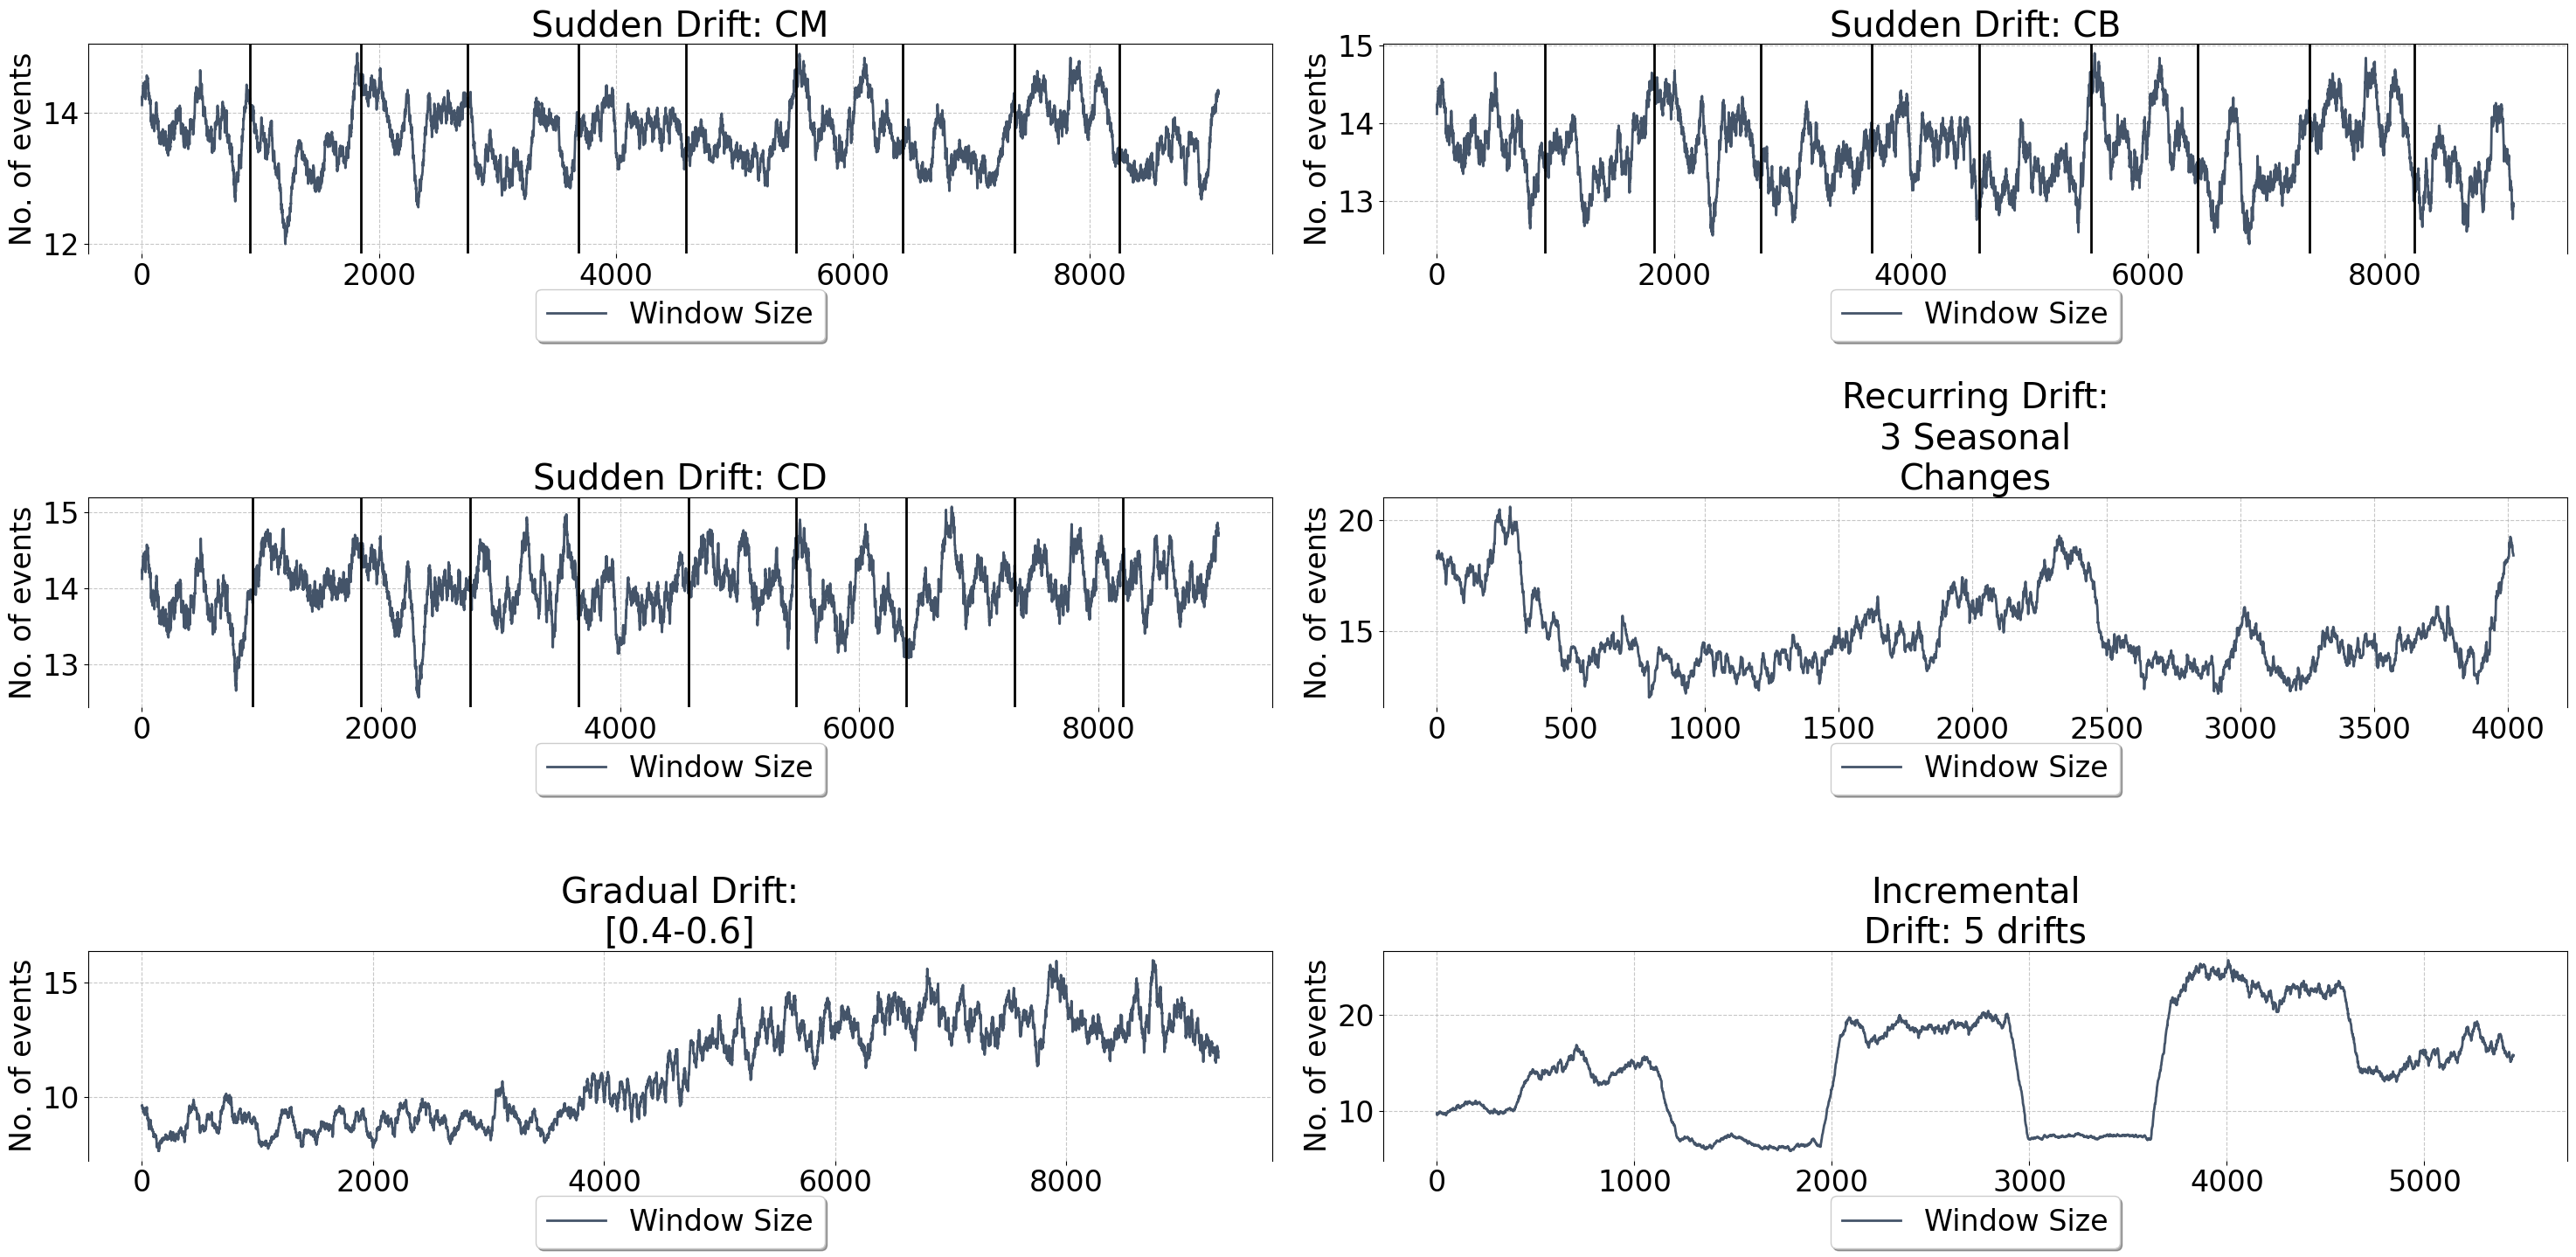

In [2]:
import numpy as np
from copy import deepcopy
from src.utils.plotter_utils import CombinedPlotter
from os.path import isfile, join, abspath
from os import listdir
from src.utils.plotter import Plotter
import pandas as pd
from typing import List
from src.utils.methods import combine_figures

PATH: str = "../benchmarks/concept_drift_synthetic/"
files_with_full_path = [abspath(join(PATH, f)) for f in listdir(PATH) if isfile(join(PATH, f))]
figs: List[plt.Figure] = []
plots: List[Plotter] = []
# log_path.split("/")[-1].replace(".csv", "")

def get_log_data(log_path: str) -> pd.DataFrame:
    RESULT_DF:pd.DataFrame = pd.read_csv(log_path)
    return RESULT_DF

def to_list(df: pd.DataFrame, column: str | int = "No. of events", window: int = 100) -> List[int]:
    return list(df[column].rolling(window=window).mean().dropna())

def to_list_2(df: pd.DataFrame, column: str | int = "No. of events", window: int = 100) -> List[int]:
    rolling_mean = df[column].rolling(window=window).median()
    rolling_mean.iloc[-window//2:] = rolling_mean.iloc[-window//2]
    rolling_mean.iloc[:window//2] = rolling_mean.iloc[window//2]
    return list(rolling_mean)

plotter = Plotter(
    title= "",
    y_axis_start_at_zero=False,
    columns=2
)


df_1: pd.DataFrame = get_log_data(PATH + "cm-10000.csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_1)),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_1)))
    ),
    vertical_lines=[(p, "black", 2, "", "bottom") for p in calculate_10_percent_indexes(df_1, len_map["cm-10000.csv"])],
    title="Sudden Drift: CM"
)


df_2: pd.DataFrame = get_log_data(PATH + "cb-10000.csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_2)),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_2)))
    ),
    vertical_lines=[(p, "black", 2, "", "bottom") for p in calculate_10_percent_indexes(df_2, len_map["cb-10000.csv"])],
    title="Sudden Drift: CB"
)


df_3: pd.DataFrame = get_log_data(PATH + "cd-10000.csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_3)),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_3)))
    ),
    vertical_lines=[(p, "black", 2, "", "bottom") for p in calculate_10_percent_indexes(df_3, len_map["cd-10000.csv"])],
    title="Sudden Drift: CD"
)


df_4: pd.DataFrame = get_log_data("../benchmarks/concept_drifts_real/recurring[3Changes_].csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_4, column="0")),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_4, column="0")))
    ),
    title="Recurring Drift: 3 Seasonal Changes"
)


df_5: pd.DataFrame = get_log_data("../benchmarks/concept_drifts_real/gradual[0.4-0.6]_10000_traces.csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_5, column="0")),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_5, column="0")))
    ),
    title="Gradual Drift: [0.4-0.6]"
)


df_6: pd.DataFrame = get_log_data("../benchmarks/concept_drifts_real/incremental[5].csv")
plotter.add_subplot(
    [
        (f"Window Size", to_list(df_6, column="0")),
    ],
    y_label="No. of events",
    x_range=list(
        range(len(to_list(df_6, column="0")))
    ),
    title="Incremental Drift: 5 drifts"
)

fig = plotter.plot(fig_width=30, x_label="Window Index", fig_height_per_plot=5, disable_show=True, title_wrap_length=16)
fig = None



window_sizes = list(df_1["No. of events"])
drift_points = calculate_10_percent_indexes(df_1, len_map["cm-10000.csv"])

metrics = analyze_window_adaptation(window_sizes, drift_points)
print("Analysis Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

print("\sawasdsd")

window_sizes = to_list(df_5, column="0")
drift_range = (0.4, 0.6)  # Drift occurs between 30% and 60% of the log

metrics = analyze_gradual_drift_adaptation(window_sizes, drift_range)
print("\nAnalysis Results:")
for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")